In [1]:
import pandas as pd
import numpy as np
import chess
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")


In [2]:
file_path = 'chessData.csv'
data = pd.read_csv(file_path)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   FEN         object
 1   Evaluation  object
dtypes: object(2)
memory usage: 197.7+ MB
None


,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [3]:
print("Missing vals per column:\n", data.isnull().sum())


Missing vals per column:
 FEN           0
Evaluation    0
dtype: int64


In [4]:
# Remove outliers beyond a threshold
# this code: keep only evaluations within ±5000 centipawns. maybe double check where we should cut off outliers
# data = data[(data['Evaluation'] > -5000) & (data['Evaluation'] < 5000)]

In [5]:
data['Evaluation'] = pd.to_numeric(data['Evaluation'], errors='coerce')

max_eval = data['Evaluation'].max()
min_eval = data['Evaluation'].min()

print(f"Maximum Evaluation: {max_eval}")
print(f"Minimum Evaluation: {min_eval}")

Maximum Evaluation: 15319.0
Minimum Evaluation: -15312.0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

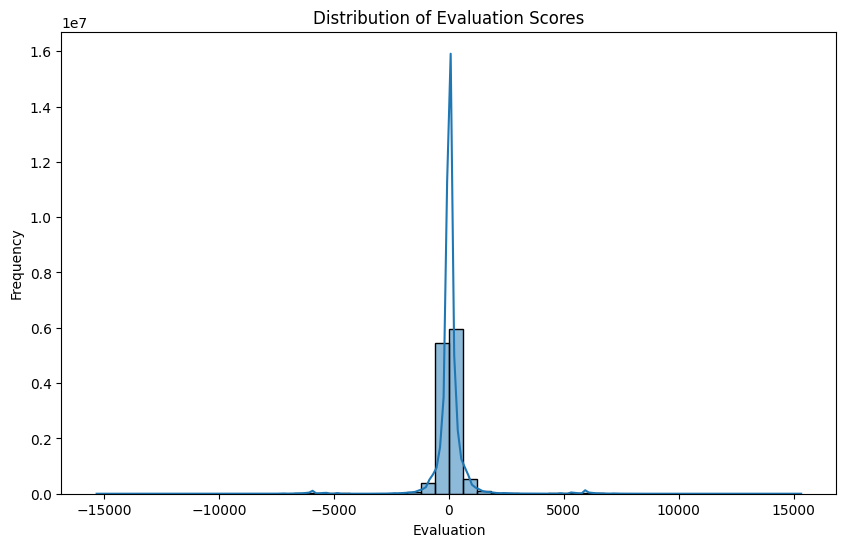

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Evaluation'], bins=50, kde=True)
plt.xlabel('Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Evaluation Scores')
plt.show()

In [8]:
non_numeric_values = data[pd.to_numeric(data['Evaluation'], errors='coerce').isna()]
print("Non-numeric values in Evaluation column:")
print(non_numeric_values[['Evaluation']])

Non-numeric values in Evaluation column:
          Evaluation
59               NaN
60               NaN
61               NaN
62               NaN
1440             NaN
...              ...
12957453         NaN
12957454         NaN
12957551         NaN
12957552         NaN
12957780         NaN

[190154 rows x 1 columns]


In [9]:
# # means forced checkmate, could replace them with a really high positive score?:

# Replace '#+X' with a large positive value and '#-X' with a large negative value
data['Evaluation'] = data['Evaluation'].replace(
    {r'^\#\+.*': '10000', r'^\#\-.*': '-10000'}, regex=True
)


In [10]:
# Drop NaN values
data.dropna(inplace=True)

non_numeric_values = data[pd.to_numeric(data['Evaluation'], errors='coerce').isna()]
print("Non-numeric values in Evaluation column:")
print(non_numeric_values[['Evaluation']])

Non-numeric values in Evaluation column:
Empty DataFrame
Columns: [Evaluation]
Index: []


In [11]:
import torch

In [12]:
# FNN, then try RELU or sigmoid activation function
# first want to convert our data into grids or matrices. might want to convert all the chess pieces into numbers
PIECE_TO_INT_2 = {key: i for i, key in enumerate(["r", "n", "b", "q", "k", "p", "R", "N", "B", "Q", "K", "P"])}

def fen_to_tensor(fen: str) -> torch.Tensor:
    """
    Convert a FEN string into a 3D tensor representation of the board.
    Args:
        fen (str): Full FEN string.
    Returns:
        torch.Tensor: 3D tensor with dimensions (12, 8, 8).
    """
    # Extract board layout (first part of FEN)
    board_layout = fen.split()[0].strip()

    board_tensor = []
    for piece in PIECE_TO_INT_2.keys():  # Going through every piece type
        piece_matrix = []
        for row in board_layout.split("/"):  # Split the FEN into rows
            row_vec = []
            for element in row:  # Check each piece in the row
                if element.isalpha():  # If it's a piece
                    row_vec.append(1 if element == piece else 0)
                elif element.isdigit():  # If it's a number (of empty squares)
                    row_vec.extend([0] * int(element))
                else:
                    raise ValueError(f"Invalid FEN character: {element}")
            # Ensure 8 columns per row
            assert len(row_vec) == 8, f"Row length mismatch: {row_vec}"
            piece_matrix.append(row_vec)

        # Ensure 8 rows per piece
        assert len(piece_matrix) == 8, f"Matrix size mismatch for piece {piece}"
        board_tensor.append(piece_matrix)

    # Ensure 12 slices (one for each piece type)
    assert len(board_tensor) == 12, "Board tensor size mismatch"

    return torch.tensor(board_tensor, dtype=torch.float32)

In [13]:
# train test split 

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


In [14]:
import torch.nn as nn
import torch.optim as optim
# ! pip install torchvision
import torchvision
from torchvision import transforms
from itertools import islice
from torch.utils.data import DataLoader

In [15]:
# put the data through transformation first
# can make a custom dataset
from torch.utils.data import Dataset
from FEN_to_vector import to_vector

class ChessDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the FEN strings and target evaluations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the FEN string and target evaluation
        fen = self.dataframe.iloc[idx]['FEN']
        evaluation = self.dataframe.iloc[idx]['Evaluation']

        board_vector = fen_to_tensor(fen)


        # Convert FEN to tensor
        board_tensor = board_vector.clone().detach()

        return board_tensor, torch.tensor(float(evaluation), dtype=torch.float32)


In [16]:
portioned_train_data = train_data.sample(frac=0.1, random_state=42)
portioned_val_data = val_data.sample(frac=0.1, random_state=42)
portioned_test_data = test_data.sample(frac=0.1, random_state=42)

train_dataset = ChessDataset(portioned_train_data)
val_dataset = ChessDataset(portioned_val_data)
test_dataset = ChessDataset(portioned_test_data)

batch = 32
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)


In [17]:
num_batches = len(train_loader)

print(f"Total number of batches: {num_batches}")

Total number of batches: 27930


In [18]:
# simple chess CNN
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(12, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 1)  # Simplified fully connected layer
        )

    def forward(self, x):
        # Ensure the input has the right shape for Conv2d
        if x.dim() == 3:
            x = x.unsqueeze(0)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [19]:
# This is for me because I have a macbook :'(
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = ChessNN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001) # initial learning rate 0.001

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
batch_limit = 50  # only process 10 batches 

model.eval()
val_predictions_before = []
val_targets_before = []

with torch.no_grad():
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break  # Stop after processing 'batch_limit' batches

        board_tensors, targets = board_tensors.to(device), targets.to(device)
        outputs = model(board_tensors)

        val_predictions_before.extend(outputs.squeeze().cpu().numpy())  # Store predictions
        val_targets_before.extend(targets.cpu().numpy())  # Store true targets

# Compute Mean Squared Error before training
mse_val_before = mean_squared_error(val_targets_before, val_predictions_before)
print(f"MSE before training: {mse_val_before:.4f}")

MSE before training: 523929.0000


In [23]:
epochs = 10  # Set to 1 for a quick test
batch_limit = 50  # only process 10 batches 
losses = []

for epoch in range(epochs):
    model.train()  
    total_loss = 0

    for i, (board_tensors, targets) in enumerate(train_loader):
        if i >= batch_limit:  # Stop after processing a limited number of batches
            break
        
        board_tensors, targets = board_tensors.to(device), targets.to(device)

        if board_tensors.dim() == 3:
            board_tensors = board_tensors.unsqueeze(0)

        # Forward pass
        predictions = model(board_tensors)
        loss = loss_fn(predictions.squeeze(), targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss / batch_limit)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / (batch_limit):.4f}")


Epoch [1/10], Loss: 539815.3957
Epoch [2/10], Loss: 588267.5139
Epoch [3/10], Loss: 589650.0522
Epoch [4/10], Loss: 885032.6358
Epoch [5/10], Loss: 706777.3905
Epoch [6/10], Loss: 838765.3681
Epoch [7/10], Loss: 541016.2190
Epoch [8/10], Loss: 634426.1397
Epoch [9/10], Loss: 587259.5058
Epoch [10/10], Loss: 594434.4576


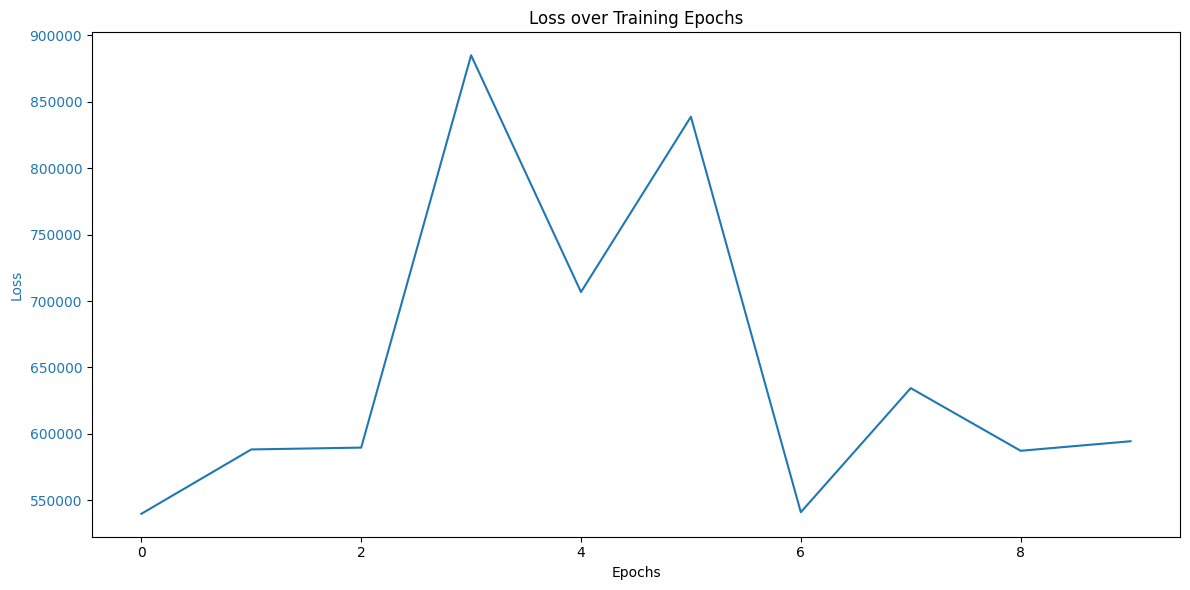

In [24]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')


plt.title('Loss over Training Epochs')
fig.tight_layout()
plt.show()

In [25]:
model.eval()
val_predictions = []
val_targets = []

with torch.no_grad():
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break  # Stop after processing 'batch_limit' batches

        board_tensors, targets = board_tensors.to(device), targets.to(device)
        outputs = model(board_tensors)

        val_predictions.extend(outputs.squeeze().cpu().numpy())  # Store predictions
        val_targets.extend(targets.cpu().numpy())  # Store true targets

# Compute Mean Squared Error after evaluation
mse_val = mean_squared_error(val_targets, val_predictions)
print(f"Validation MSE: {mse_val:.4f}")

Validation MSE: 521371.1875


In [26]:
model.eval()  # Set model to evaluation mode
val_loss = 0

with torch.no_grad():  # No gradients are calculated during evaluation
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break

        board_tensors, targets = board_tensors.to(device), targets.to(device)

        # Forward pass
        predictions = model(board_tensors)
        loss = loss_fn(predictions.squeeze(), targets)
        val_loss += loss.item()  # Accumulate loss

print(f"Validation Loss: {val_loss / batch_limit:.4f}")

Validation Loss: 521371.2411
